## 최종 결과값 값 산출

In [5]:
os.getcwd()

'/home/yeonho/final_saved_model'

In [6]:
from new_model import * 

In [7]:
def test_model(model):
    model.to(device)
    model.eval()

    total_examples = 0
    correct_examples = 0
    softmax = torch.nn.Softmax(dim=1)

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            pred = model(inputs)
            total_examples += inputs.shape[0]

            out = softmax(pred)
            out = torch.max(out, 1)

            correct_examples += torch.sum(targets==out[1]).cpu().data.numpy().tolist()

    avg_acc = correct_examples / total_examples
    print("Total examples is {}, correct examples is {}; Test accuracy: {}".format(total_examples, correct_examples, avg_acc))

## 1. CIFAR10

In [10]:
#Data 다운로드 경로지정
batch_size = 128


#Data Process 
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]) 

transform_val = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))])

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))])

train_CIFAR10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

test_CIFAR10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

num_train = int(1.0 * len(train_CIFAR10) * 95 / 100)
num_val = len(train_CIFAR10) - num_train
train_CIFAR10, val_CIFAR10 = torch.utils.data.random_split(train_CIFAR10, [num_train, num_val])

train_loader = torch.utils.data.DataLoader(train_CIFAR10, batch_size=batch_size, shuffle=True, num_workers=2) #num_workers는 데이터 로드시 sub process 몇개 쓸거냐 
val_loader = torch.utils.data.DataLoader(val_CIFAR10, batch_size=batch_size,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_CIFAR10, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### 1-1. Wide Resnet

In [11]:
#wide_resnet 28xn의 결과값
for i in [1,2,4,10] :
    model = Wide_ResNet(28, i, 0.3, 10).to(device)
    checkpoint = torch.load(f"./1.Wide_ResNet_model/saved_model/WR_28x{i}_cifar10.pth")
    model.load_state_dict(checkpoint['state_dict'])
    test_model(model)



| Wide-Resnet 28x1
Total examples is 10000, correct examples is 9307; Test accuracy: 0.9307
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9491; Test accuracy: 0.9491
| Wide-Resnet 28x4
Total examples is 10000, correct examples is 9538; Test accuracy: 0.9538
| Wide-Resnet 28x10
Total examples is 10000, correct examples is 9572; Test accuracy: 0.9572


### 1-2. Knowledge distillation

In [15]:
## 28x2 to 28x1
t = 4
s = 2 
T = 20

print(f"T가 {T}일때의 28x{t} to 28x{s} distillation 결과 값")
for seed in [10, 100, 777] :
    # 학습에 사용할 모델 생성
    teacher = Wide_ResNet(28, t, 0.3, 10).to(device)
    checkpoint_path = f"./1.Wide_ResNet_model/saved_model/WR_28x{t}_cifar10.pth"
    checkpoint = torch.load(checkpoint_path)
    teacher.load_state_dict(checkpoint['state_dict'])

    student = Wide_ResNet(28, s, 0.3, 10).to(device)

    # 모델 평가
    checkpoint_path = f"./2.Knowledge_Distillation/new_seed_{seed}_CIFAR10/KD_{t}to{s}_T={T}.pth"
    checkpoint = torch.load(checkpoint_path)
    student.load_state_dict(checkpoint['state_dict'])
    test_model(student)

T가 20일때의 28x4 to 28x2 distillation 결과 값
| Wide-Resnet 28x4
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9524; Test accuracy: 0.9524
| Wide-Resnet 28x4
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9503; Test accuracy: 0.9503
| Wide-Resnet 28x4
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9499; Test accuracy: 0.9499


In [13]:
## 28x2 to 28x1
t = 2
s = 1 

for T in [4,10,20]:
    print(f"T가 {T}일때의 28x{t} to 28x{s} distillation 결과 값")
    for seed in [10, 100, 777] :
        # 학습에 사용할 모델 생성
        teacher = Wide_ResNet(28, t, 0.3, 10).to(device)
        checkpoint_path = f"./1.Wide_ResNet_model/saved_model/WR_28x{t}_cifar10.pth"
        checkpoint = torch.load(checkpoint_path)
        teacher.load_state_dict(checkpoint['state_dict'])

        student = Wide_ResNet(28, s, 0.3, 10).to(device)

        # 모델 평가
        checkpoint_path = f"./2.Knowledge_Distillation/save_seed{seed}_CIFAR10/KD_{t}to{s}_T={T}.pth"
        checkpoint = torch.load(checkpoint_path)
        student.load_state_dict(checkpoint['state_dict'])
        test_model(student)

T가 4일때의 28x2 to 28x1 distillation 결과 값
| Wide-Resnet 28x2
| Wide-Resnet 28x1
Total examples is 10000, correct examples is 9354; Test accuracy: 0.9354
| Wide-Resnet 28x2
| Wide-Resnet 28x1
Total examples is 10000, correct examples is 9413; Test accuracy: 0.9413
| Wide-Resnet 28x2
| Wide-Resnet 28x1
Total examples is 10000, correct examples is 9353; Test accuracy: 0.9353
T가 10일때의 28x2 to 28x1 distillation 결과 값
| Wide-Resnet 28x2
| Wide-Resnet 28x1


KeyboardInterrupt: 

In [ ]:
## 28x4 to 28x2
t = 4
s = 2 

for T in [4,10,20]:
    print(f"T가 {T}일때의 28x{t} to 28x{s} distillation 결과 값")
    for seed in [10, 100, 777] :
        # 학습에 사용할 모델 생성
        teacher = Wide_ResNet(28, t, 0.3, 10).to(device)
        checkpoint_path = f"./1.Wide_ResNet_model/saved_model/WR_28x{t}_cifar10.pth"
        checkpoint = torch.load(checkpoint_path)
        teacher.load_state_dict(checkpoint['state_dict'])

        student = Wide_ResNet(28, s, 0.3, 10).to(device)

        # 모델 평가
        checkpoint_path = f"./2.Knowledge_Distillation/save_seed{seed}_CIFAR10/KD_{t}to{s}_T={T}.pth"
        checkpoint = torch.load(checkpoint_path)
        student.load_state_dict(checkpoint['state_dict'])
        test_model(student)

T가 4일때의 28x4 to 28x2 distillation 결과 값
| Wide-Resnet 28x4
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9514; Test accuracy: 0.9514
| Wide-Resnet 28x4
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9475; Test accuracy: 0.9475
| Wide-Resnet 28x4
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9481; Test accuracy: 0.9481
T가 10일때의 28x4 to 28x2 distillation 결과 값
| Wide-Resnet 28x4
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9483; Test accuracy: 0.9483
| Wide-Resnet 28x4
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9518; Test accuracy: 0.9518
| Wide-Resnet 28x4
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9490; Test accuracy: 0.949
T가 20일때의 28x4 to 28x2 distillation 결과 값
| Wide-Resnet 28x4
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9493; Test accuracy: 0.9493
| Wide-Resnet 28x4
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9514; Test accuracy: 0

In [ ]:
## 28x10 to 28x2
t = 10
s = 2

for T in [4,10,20]:
    print(f"T가 {T}일때의 28x{t} to 28x{s} distillation 결과 값")
    for seed in [10, 100, 777] :
        # 학습에 사용할 모델 생성
        teacher = Wide_ResNet(28, t, 0.3, 10).to(device)
        checkpoint_path = f"./1.Wide_ResNet_model/saved_model/WR_28x{t}_cifar10.pth"
        checkpoint = torch.load(checkpoint_path)
        teacher.load_state_dict(checkpoint['state_dict'])

        student = Wide_ResNet(28, s, 0.3, 10).to(device)

        # 모델 평가
        checkpoint_path = f"./2.Knowledge_Distillation/save_seed{seed}_CIFAR10/KD_{t}to{s}_T={T}.pth"
        checkpoint = torch.load(checkpoint_path)
        student.load_state_dict(checkpoint['state_dict'])
        test_model(student)

T가 4일때의 28x10 to 28x2 distillation 결과 값
| Wide-Resnet 28x10
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9495; Test accuracy: 0.9495
| Wide-Resnet 28x10
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9501; Test accuracy: 0.9501
| Wide-Resnet 28x10
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9481; Test accuracy: 0.9481
T가 10일때의 28x10 to 28x2 distillation 결과 값
| Wide-Resnet 28x10
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9495; Test accuracy: 0.9495
| Wide-Resnet 28x10
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9487; Test accuracy: 0.9487
| Wide-Resnet 28x10
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9505; Test accuracy: 0.9505
T가 20일때의 28x10 to 28x2 distillation 결과 값
| Wide-Resnet 28x10
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9500; Test accuracy: 0.95
| Wide-Resnet 28x10
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 9507; Test a

In [ ]:
## 28x10 to 28x4
t = 10
s = 4

for T in [4,10,20]:
    print(f"T가 {T}일때의 28x{t} to 28x{s} distillation 결과 값")
    for seed in [10, 100, 777] :
        # 학습에 사용할 모델 생성
        teacher = Wide_ResNet(28, t, 0.3, 10).to(device)
        checkpoint_path = f"./1.Wide_ResNet_model/saved_model/WR_28x{t}_cifar10.pth"
        checkpoint = torch.load(checkpoint_path)
        teacher.load_state_dict(checkpoint['state_dict'])

        student = Wide_ResNet(28, s, 0.3, 10).to(device)

        # 모델 평가
        checkpoint_path = f"./2.Knowledge_Distillation/save_seed{seed}_CIFAR10/KD_{t}to{s}_T={T}.pth"
        checkpoint = torch.load(checkpoint_path)
        student.load_state_dict(checkpoint['state_dict'])
        test_model(student)

T가 4일때의 28x10 to 28x4 distillation 결과 값
| Wide-Resnet 28x10


NameError: name 'device' is not defined

### 1.3. Node Sparse Modeling

In [20]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


In [18]:
## 28x2 with 0.5
basic = 2

for seed in [10, 100, 777] :
    print(f'seed{seed}에서의 결과값 시작')
    lr = 0.02
    model = Wide_ResNet(28, basic, 0.3, 10).to(device)
    ## test
    checkpoint_path = f"./practice_CIFAR10/28x{basic}_multistepLR_lr{lr}_seed{seed}.pth"
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    test_model(model)   
        
    model = Wide_ResNet(28, basic, 0.3, 10).to(device)
    ## test
    checkpoint_path = f"./save_seed{seed}_CIFAR10/28x{basic}_cosine_lr{lr}.pth"
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    test_model(model)  

seed10에서의 결과값 시작
| Wide-Resnet 28x2


FileNotFoundError: [Errno 2] No such file or directory: './practice_CIFAR10/28x2_multistepLR_lr0.02_seed10.pth'

In [25]:
os.getcwd()

'/home/yeonho/final_saved_model'

In [26]:
## 28x2 with 0.5
basic = 4

for seed in [10, 100, 777] :
    print(f'seed{seed}에서의 결과값 시작')
    lr = 0.02
    model = Wide_ResNet(28, basic, 0.3, 10).to(device)
    ## test
    checkpoint_path = f"./3.node_sparse(fine tuning)/save_CIFAR10/28x{basic}_multistepLR_lr{lr}_seed{seed}.pth"
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    test_model(model)   
        
    # model = Wide_ResNet(28, basic, 0.3, 10).to(device)
    # ## test
    # checkpoint_path = f"./save_seed{seed}_CIFAR10/28x{basic}_cosine_lr{lr}.pth"
    # checkpoint = torch.load(checkpoint_path)
    # model.load_state_dict(checkpoint['state_dict'])
    # test_model(model)  

seed10에서의 결과값 시작
| Wide-Resnet 28x4
Total examples is 10000, correct examples is 9407; Test accuracy: 0.9407
seed100에서의 결과값 시작
| Wide-Resnet 28x4
Total examples is 10000, correct examples is 9418; Test accuracy: 0.9418
seed777에서의 결과값 시작
| Wide-Resnet 28x4


FileNotFoundError: [Errno 2] No such file or directory: './3.node_sparse(fine tuning)/save_CIFAR10/28x4_multistepLR_lr0.02_seed777.pth'

In [22]:
## 28x10 with 0.6
basic = 10

for seed in [10, 100, 777] :
    print(f'seed{seed}에서의 결과값 시작')
    for lr in [0.004, 0.02]:
        model = Wide_ResNet(28, basic, 0.3, 10).to(device)
        ## test
        checkpoint_path = f"./save_seed{seed}_CIFAR10/28x{basic}_0.6_multistepLR_lr{lr}.pth"
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        test_model(model)   
        
    for lr in [0.004, 0.02]:
        model = Wide_ResNet(28, basic, 0.3, 10).to(device)
        ## test
        checkpoint_path = f"./save_seed{seed}_CIFAR10/28x{basic}_0.6_cosine_lr{lr}.pth"
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        test_model(model)  

seed10에서의 결과값 시작
| Wide-Resnet 28x10


FileNotFoundError: [Errno 2] No such file or directory: './save_seed10_CIFAR10/28x10_0.6_multistepLR_lr0.004.pth'

In [ ]:
## 28x10 with 0.8
basic = 10

for seed in [10, 100, 777] :
    print(f'seed{seed}에서의 결과값 시작')
    for lr in [0.004, 0.02]:
        model = Wide_ResNet(28, basic, 0.3, 10).to(device)
        ## test
        checkpoint_path = f"./save_seed{seed}_CIFAR10/28x{basic}_0.8_multistepLR_lr{lr}.pth"
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        test_model(model)   
        
    for lr in [0.004, 0.02]:
        model = Wide_ResNet(28, basic, 0.3, 10).to(device)
        ## test
        checkpoint_path = f"./save_seed{seed}_CIFAR10/28x{basic}_0.8_cosine_lr{lr}.pth"
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        test_model(model)  

seed10에서의 결과값 시작
| Wide-Resnet 28x10
Total examples is 10000, correct examples is 9500; Test accuracy: 0.95
| Wide-Resnet 28x10
Total examples is 10000, correct examples is 9535; Test accuracy: 0.9535
| Wide-Resnet 28x10
Total examples is 10000, correct examples is 9533; Test accuracy: 0.9533
| Wide-Resnet 28x10
Total examples is 10000, correct examples is 9551; Test accuracy: 0.9551
seed100에서의 결과값 시작
| Wide-Resnet 28x10
Total examples is 10000, correct examples is 9515; Test accuracy: 0.9515
| Wide-Resnet 28x10
Total examples is 10000, correct examples is 9564; Test accuracy: 0.9564
| Wide-Resnet 28x10
Total examples is 10000, correct examples is 9561; Test accuracy: 0.9561
| Wide-Resnet 28x10
Total examples is 10000, correct examples is 9559; Test accuracy: 0.9559
seed777에서의 결과값 시작
| Wide-Resnet 28x10
Total examples is 10000, correct examples is 9536; Test accuracy: 0.9536
| Wide-Resnet 28x10
Total examples is 10000, correct examples is 9523; Test accuracy: 0.9523
| Wide-Resnet 28x10

## 2. CIFAR100

In [ ]:
#CIFAR 100 : Data 다운로드 경로지정
batch_size = 128

#Data Process
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]) 

transform_val = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]) 

transform_test = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]) 

train_CIFAR100 = torchvision.datasets.CIFAR100(root='../data', train=True, download=True, transform=transform_train)

test_CIFAR100 = torchvision.datasets.CIFAR100(root='../data', train=False, download=True, transform=transform_test)

num_train = int(1.0 * len(train_CIFAR100) * 95 / 100)
num_val = len(train_CIFAR100) - num_train
train_CIFAR100, val_CIFAR100 = torch.utils.data.random_split(train_CIFAR100, [num_train, num_val])

train_loader = torch.utils.data.DataLoader(train_CIFAR100, batch_size=batch_size, shuffle=True, num_workers=2) #num_workers는 데이터 로드시 sub process 몇개 쓸거냐 
val_loader = torch.utils.data.DataLoader(val_CIFAR100, batch_size=batch_size,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_CIFAR100, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### 1-1. Wide Resnet

In [ ]:
#wide_resnet 28xn의 결과값
for i in [1,2,4,10] :
    model = Wide_ResNet(28, i, 0.3, 100).to(device)
    checkpoint = torch.load(f"./1.Wide_ResNet_model/saved_model/WR_28x{i}_cifar100.pth")
    model.load_state_dict(checkpoint['state_dict'])
    test_model(model)

| Wide-Resnet 28x1


NameError: name 'device' is not defined

### 1-2. Knowledge distillation

In [ ]:
## 28x2 to 28x1
t = 2
s = 1 

for T in [4,10,20]:
    print(f"T가 {T}일때의 28x{t} to 28x{s} distillation 결과 값")
    for seed in [10, 100, 777] :
        # 학습에 사용할 모델 생성
        teacher = Wide_ResNet(28, t, 0.3, 100).to(device)
        checkpoint_path = f"./1.Wide_ResNet_model/saved_model/WR_28x{t}_cifar100.pth"
        checkpoint = torch.load(checkpoint_path)
        teacher.load_state_dict(checkpoint['state_dict'])

        student = Wide_ResNet(28, s, 0.3, 100).to(device)

        # 모델 평가
        checkpoint_path = f"./2.Knowledge_Distillation/save_seed{seed}_CIFAR100/KD_{t}to{s}_T={T}.pth"
        checkpoint = torch.load(checkpoint_path)
        student.load_state_dict(checkpoint['state_dict'])
        test_model(student)

T가 4일때의 28x2 to 28x1 distillation 결과 값
| Wide-Resnet 28x2
| Wide-Resnet 28x1
Total examples is 10000, correct examples is 7135; Test accuracy: 0.7135
| Wide-Resnet 28x2
| Wide-Resnet 28x1
Total examples is 10000, correct examples is 7083; Test accuracy: 0.7083
| Wide-Resnet 28x2
| Wide-Resnet 28x1
Total examples is 10000, correct examples is 7103; Test accuracy: 0.7103
T가 10일때의 28x2 to 28x1 distillation 결과 값
| Wide-Resnet 28x2
| Wide-Resnet 28x1
Total examples is 10000, correct examples is 7162; Test accuracy: 0.7162
| Wide-Resnet 28x2
| Wide-Resnet 28x1
Total examples is 10000, correct examples is 7148; Test accuracy: 0.7148
| Wide-Resnet 28x2
| Wide-Resnet 28x1
Total examples is 10000, correct examples is 7144; Test accuracy: 0.7144
T가 20일때의 28x2 to 28x1 distillation 결과 값
| Wide-Resnet 28x2
| Wide-Resnet 28x1
Total examples is 10000, correct examples is 7185; Test accuracy: 0.7185
| Wide-Resnet 28x2
| Wide-Resnet 28x1
Total examples is 10000, correct examples is 7189; Test accuracy: 

In [ ]:
## 28x4 to 28x2
t = 4
s = 2 

for T in [4,10,20]:
    print(f"T가 {T}일때의 28x{t} to 28x{s} distillation 결과 값")
    for seed in [10, 100, 777] :
        # 학습에 사용할 모델 생성
        teacher = Wide_ResNet(28, t, 0.3, 100).to(device)
        checkpoint_path = f"./1.Wide_ResNet_model/saved_model/WR_28x{t}_cifar100.pth"
        checkpoint = torch.load(checkpoint_path)
        teacher.load_state_dict(checkpoint['state_dict'])

        student = Wide_ResNet(28, s, 0.3, 100).to(device)

        # 모델 평가
        checkpoint_path = f"./2.Knowledge_Distillation/save_seed{seed}_CIFAR100/KD_{t}to{s}_T={T}.pth"
        checkpoint = torch.load(checkpoint_path)
        student.load_state_dict(checkpoint['state_dict'])
        test_model(student)

T가 4일때의 28x4 to 28x2 distillation 결과 값


NameError: name 'Wide_ResNet' is not defined

In [ ]:
## 28x10 to 28x2
t = 10
s = 2 

for T in [4,10,20]:
    print(f"T가 {T}일때의 28x{t} to 28x{s} distillation 결과 값")
    for seed in [10, 100, 777] :
        # 학습에 사용할 모델 생성
        teacher = Wide_ResNet(28, t, 0.3, 100).to(device)
        checkpoint_path = f"./1.Wide_ResNet_model/saved_model/WR_28x{t}_cifar100.pth"
        checkpoint = torch.load(checkpoint_path)
        teacher.load_state_dict(checkpoint['state_dict'])

        student = Wide_ResNet(28, s, 0.3, 100).to(device)

        # 모델 평가
        checkpoint_path = f"./2.Knowledge_Distillation/save_seed{seed}_CIFAR100/KD_{t}to{s}_T={T}.pth"
        checkpoint = torch.load(checkpoint_path)
        student.load_state_dict(checkpoint['state_dict'])
        test_model(student)

T가 4일때의 28x10 to 28x2 distillation 결과 값
| Wide-Resnet 28x10
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 7544; Test accuracy: 0.7544
| Wide-Resnet 28x10
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 7548; Test accuracy: 0.7548
| Wide-Resnet 28x10
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 7577; Test accuracy: 0.7577
T가 10일때의 28x10 to 28x2 distillation 결과 값
| Wide-Resnet 28x10
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 7585; Test accuracy: 0.7585
| Wide-Resnet 28x10
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 7606; Test accuracy: 0.7606
| Wide-Resnet 28x10
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 7571; Test accuracy: 0.7571
T가 20일때의 28x10 to 28x2 distillation 결과 값
| Wide-Resnet 28x10
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 7575; Test accuracy: 0.7575
| Wide-Resnet 28x10
| Wide-Resnet 28x2
Total examples is 10000, correct examples is 7626; Test

In [ ]:
## 28x10 to 28x4
t = 10
s = 4

for T in [4,10,20]:
    print(f"T가 {T}일때의 28x{t} to 28x{s} distillation 결과 값")
    for seed in [10, 100, 777] :
        # 학습에 사용할 모델 생성
        teacher = Wide_ResNet(28, t, 0.3, 100).to(device)
        checkpoint_path = f"./1.Wide_ResNet_model/saved_model/WR_28x{t}_cifar100.pth"
        checkpoint = torch.load(checkpoint_path)
        teacher.load_state_dict(checkpoint['state_dict'])

        student = Wide_ResNet(28, s, 0.3, 100).to(device)

        # 모델 평가
        checkpoint_path = f"./2.Knowledge_Distillation/save_seed{seed}_CIFAR100/KD_{t}to{s}_T={T}.pth"
        checkpoint = torch.load(checkpoint_path)
        student.load_state_dict(checkpoint['state_dict'])
        test_model(student)

T가 4일때의 28x10 to 28x4 distillation 결과 값
| Wide-Resnet 28x10


NameError: name 'device' is not defined

### 1.3. Node Sparse Modeling

In [ ]:
## 28x2 with 0.5
basic = 2

for seed in [10, 100, 777] :
    print(f'seed{seed}에서의 결과값 시작')
    for lr in [0.004, 0.02]:
        model = Wide_ResNet(28, basic, 0.3, 100).to(device)
        ## test
        checkpoint_path = f"./3.node_sparse(fine tuning)/save_seed{seed}_CIFAR100/28x{basic}_multistepLR_lr{lr}.pth"
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        test_model(model)   
        
    for lr in [0.004, 0.02]:
        model = Wide_ResNet(28, basic, 0.3, 100).to(device)
        ## test
        checkpoint_path = f"./3.node_sparse(fine tuning)/save_seed{seed}_CIFAR100/28x{basic}_cosine_lr{lr}.pth"
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        test_model(model)  

seed10에서의 결과값 시작
| Wide-Resnet 28x2


FileNotFoundError: [Errno 2] No such file or directory: './save_seed10_CIFAR100/28x2_multistepLR_lr0.004.pth'

In [ ]:
## 28x4 with 0.5
basic = 4

for seed in [10, 100, 777] :
    print(f'seed{seed}에서의 결과값 시작')
    for lr in [0.004, 0.02]:
        model = Wide_ResNet(28, basic, 0.3, 100).to(device)
        ## test
        checkpoint_path = f"./3.node_sparse(fine tuning)/save_seed{seed}_CIFAR100/28x{basic}_multistepLR_lr{lr}.pth"
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        test_model(model)   
        
    for lr in [0.004, 0.02]:
        model = Wide_ResNet(28, basic, 0.3, 100).to(device)
        ## test
        checkpoint_path = f"./3.node_sparse(fine tuning)/save_seed{seed}_CIFAR100/28x{basic}_cosine_lr{lr}.pth"
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        test_model(model)  

seed10에서의 결과값 시작
| Wide-Resnet 28x4


NameError: name 'device' is not defined

In [ ]:
## 28x10 with 0.6
basic = 10

for seed in [10, 100, 777] :
    print(f'seed{seed}에서의 결과값 시작')
    for lr in [0.004, 0.02]:
        model = Wide_ResNet(28, basic, 0.3, 100).to(device)
        ## test
        checkpoint_path = f"./3.node_sparse(fine tuning)/save_seed{seed}_CIFAR100/28x{basic}_0.6_multistepLR_lr{lr}.pth"
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        test_model(model)   
        
    for lr in [0.004, 0.02]:
        model = Wide_ResNet(28, basic, 0.3, 100).to(device)
        ## test
        checkpoint_path = f"./3.node_sparse(fine tuning)/save_seed{seed}_CIFAR100/28x{basic}_0.6_cosine_lr{lr}.pth"
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        test_model(model)  

seed10에서의 결과값 시작
| Wide-Resnet 28x10


NameError: name 'device' is not defined

In [ ]:
## 28x10 with 0.8
basic = 10

for seed in [10, 100, 777] :
    print(f'seed{seed}에서의 결과값 시작')
    for lr in [0.004, 0.02]:
        model = Wide_ResNet(28, basic, 0.3, 100).to(device)
        ## test
        checkpoint_path = f"./3.node_sparse(fine tuning)/save_seed{seed}_CIFAR100/28x{basic}_0.8_multistepLR_lr{lr}.pth"
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        test_model(model)   
        
    for lr in [0.004, 0.02]:
        model = Wide_ResNet(28, basic, 0.3, 100).to(device)
        ## test
        checkpoint_path = f"./3.node_sparse(fine tuning)/save_seed{seed}_CIFAR100/28x{basic}_0.8_cosine_lr{lr}.pth"
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        test_model(model)  

## 최종 결과값 이미지 파일로 저장

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.lines import Line2D


### 1. CIFAR10

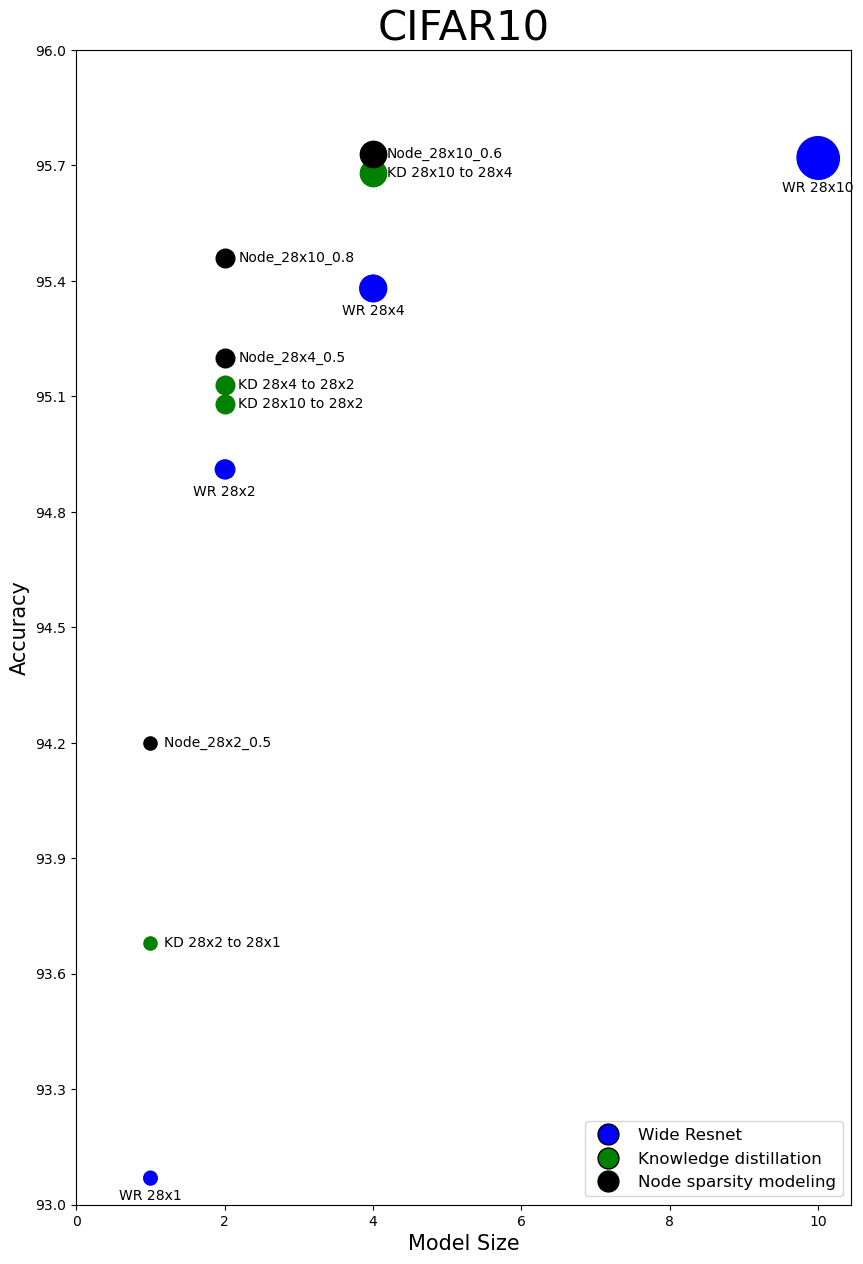

In [195]:
# X축 데이터, 여기서는 모델 크기를 의미하는 데이터로 가정
model_size = [1, 2, 4, 10]

# Y축 데이터, 여기서는 정확도를 나타내는 데이터로 가정
accuracy = [93.07, 94.91, 95.38, 95.72]

# 원형의 크기를 결정할 변수, 여기서는 모델 크기로 가정
circle_size = [size*90 for size in model_size]

# 각 모델 크기에 대한 색상 설정
colors = ['blue']

# 그래프 크기 및 제목 설정
fig = plt.figure(figsize=(10, 15))
plt.title('CIFAR10', fontsize = 30)

# 범례 항목 생성
scatter_handles = []
for i in range(len(model_size)):
    scatter_handle = plt.Line2D([0], [0], linestyle='None', markersize=10, marker='o', markerfacecolor=colors[0], markeredgecolor='none', label=f'WR 28x{model_size[0]}')
    scatter_handles.append(scatter_handle)
    
for i in range(len(model_size)):
    plt.scatter(model_size[i], accuracy[i], s=circle_size[i], color=colors[0])
    plt.annotate(f'WR 28x{model_size[i]}', (model_size[i], accuracy[i]), ha='center', va='top', xytext=(0,-(circle_size_kd[i]/30+5)), textcoords='offset points')

labels = [f'WR 28x{size}' for size in model_size]


# 산점도 그리기
plt.scatter(model_size, accuracy, s=circle_size, color=colors)

# knowledge distillation 결과 추가
model_size_kd = [1, 2, 2, 4]
accuracy_kd = [93.68, 95.13, 95.08, 95.68]
circle_size_kd = [size*90 for size in model_size_kd]
colors_kd = ['green']

labels_kd = ['KD 28x2 to 28x1', 'KD 28x4 to 28x2', 'KD 28x10 to 28x2', 'KD 28x10 to 28x4']

for i in range(len(model_size_kd)):
    plt.scatter(model_size_kd[i], accuracy_kd[i], s=circle_size_kd[i], color=colors_kd[0])
    plt.annotate(labels_kd[i], (model_size_kd[i], accuracy_kd[i]), ha='left', va='center', xytext=(10,0), textcoords='offset points')


# Node Sparsity Modeling 결과 추가
model_size_prune = [1, 2, 2, 4]
accuracy_prune = [94.20, 95.20, 95.46, 95.73]
circle_size_prune = [size*90 for size in model_size_prune]
colors_prune = ['black']

labels_prune = ['Node_28x2_0.5 ', 'Node_28x4_0.5', 'Node_28x10_0.8', 'Node_28x10_0.6']

for i in range(len(model_size_prune)):
    plt.scatter(model_size_prune[i], accuracy_prune[i], s=circle_size_prune[i], color=colors_prune[0])
    plt.annotate(labels_prune[i], (model_size_prune[i], accuracy_prune[i]), ha='left', va='center', xytext=(10,0), textcoords='offset points')

# 범례 추가
labels_all = labels + labels_kd + labels_prune
colors_all = colors + colors_kd + labels_prune
handles_all = (scatter_handles + 
               [plt.Line2D([0], [0], linestyle='None', markersize=10, marker='o', markerfacecolor=colors_prune[0], markeredgecolor='none', label=labels_prune[i]) for i in range(len(labels_prune))]
               +[plt.Line2D([0], [0], linestyle='None', markersize=10, marker='o', markerfacecolor=colors_kd[0], markeredgecolor='none', label=labels_kd[i]) for i in range(len(labels_kd))])

blue_circle = Line2D([0], [0], marker='o', color='none', label='Wide Resnet', markerfacecolor='blue', markersize=15)
green_circle = Line2D([0], [0], marker='o', color='none', label='Knowledge distillation', markerfacecolor='green', markersize=15)
black_circle = Line2D([0], [0], marker='o', color='none', label='Node sparsity modeling', markerfacecolor='black', markersize=15)

# 그래프에 범례 추가
plt.legend(handles=[blue_circle, green_circle, black_circle], 
           loc='lower right', fontsize=12)

# X축 눈금 설정
plt.xticks(np.arange(0,11,2))
# y축 범위 지정
plt.ylim(93, 96)

# y축 눈금 설정
plt.yticks(np.arange(93, 96.3, 0.3))

# 축 레이블 설정
plt.xlabel('Model Size', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)

# plt.show()

plt.savefig('result_CIFAR10.png')

### 2. CIFAR100

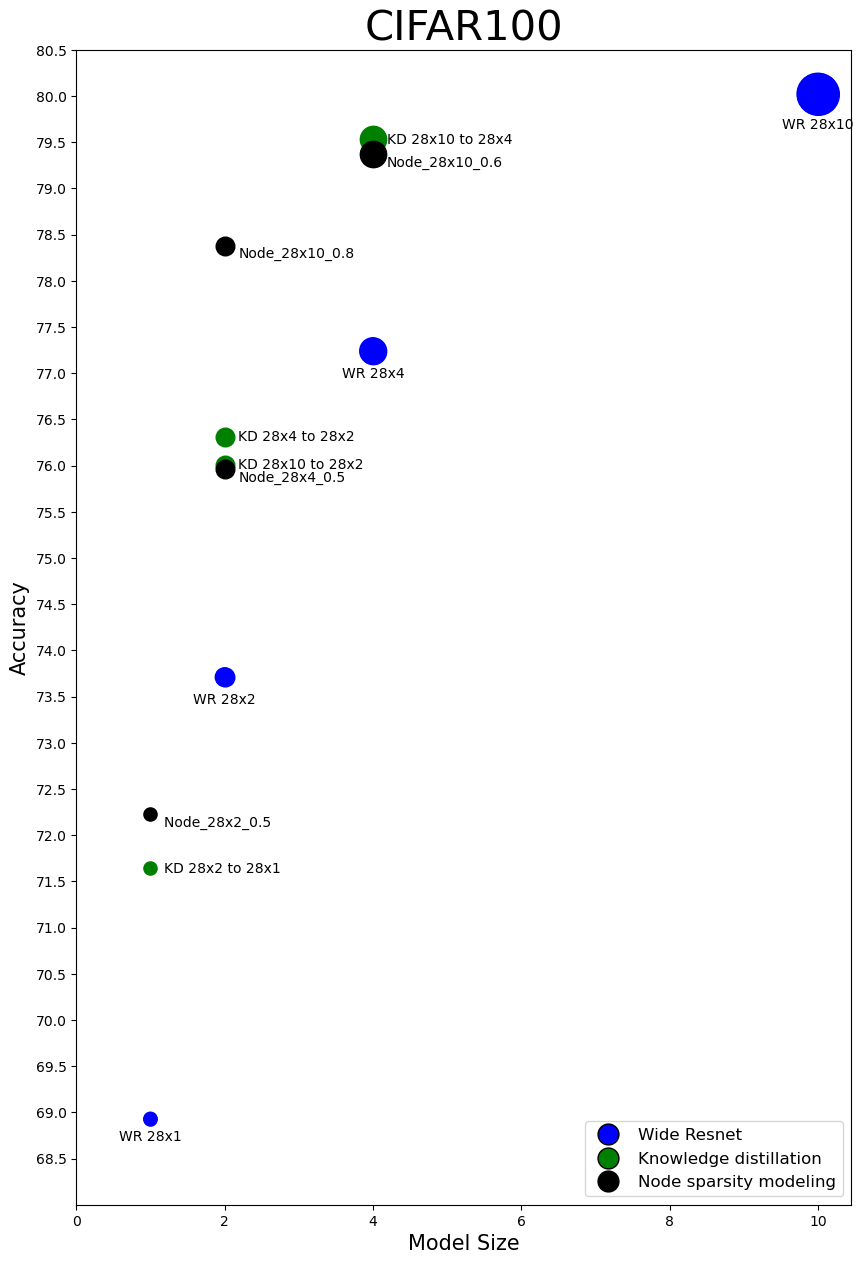

In [201]:
# X축 데이터, 여기서는 모델 크기를 의미하는 데이터로 가정
model_size = [1, 2, 4, 10]

# Y축 데이터, 여기서는 정확도를 나타내는 데이터로 가정
accuracy = [68.93, 73.71, 77.24, 80.02]

# 원형의 크기를 결정할 변수, 여기서는 모델 크기로 가정
circle_size = [size*90 for size in model_size]

# 각 모델 크기에 대한 색상 설정
colors = ['blue']

# 그래프 크기 및 제목 설정
fig = plt.figure(figsize=(10, 15))
plt.title('CIFAR100', fontsize = 30)

# 범례 항목 생성
scatter_handles = []
for i in range(len(model_size)):
    scatter_handle = plt.Line2D([0], [0], linestyle='None', markersize=10, marker='o', markerfacecolor=colors[0], markeredgecolor='none', label=f'WR 28x{model_size[0]}')
    scatter_handles.append(scatter_handle)
    
for i in range(len(model_size)):
    plt.scatter(model_size[i], accuracy[i], s=circle_size[i], color=colors[0])
    plt.annotate(f'WR 28x{model_size[i]}', (model_size[i], accuracy[i]), ha='center', va='top', xytext=(0,-(circle_size_kd[i]/30+5)), textcoords='offset points')

labels = [f'WR 28x{size}' for size in model_size]


# 산점도 그리기
plt.scatter(model_size, accuracy, s=circle_size, color=colors)

# knowledge distillation 결과 추가
model_size_kd = [1, 2, 2, 4]
accuracy_kd = [71.64, 76.31, 76.01, 79.53]
circle_size_kd = [size*90 for size in model_size_kd]
colors_kd = ['green']

labels_kd = ['KD 28x2 to 28x1', 'KD 28x4 to 28x2', 'KD 28x10 to 28x2', 'KD 28x10 to 28x4']

for i in range(len(model_size_kd)):
    plt.scatter(model_size_kd[i], accuracy_kd[i], s=circle_size_kd[i], color=colors_kd[0])
    plt.annotate(labels_kd[i], (model_size_kd[i], accuracy_kd[i]), ha='left', va='center', xytext=(10,0), textcoords='offset points')


# Node Sparsity Modeling 결과 추가
model_size_prune = [1, 2, 2, 4]
accuracy_prune = [72.23, 75.96, 78.38, 79.37]
circle_size_prune = [size*90 for size in model_size_prune]
colors_prune = ['black']

labels_prune = ['Node_28x2_0.5 ', 'Node_28x4_0.5', 'Node_28x10_0.8', 'Node_28x10_0.6']

for i in range(len(model_size_prune)):
    plt.scatter(model_size_prune[i], accuracy_prune[i], s=circle_size_prune[i], color=colors_prune[0])
    plt.annotate(labels_prune[i], (model_size_prune[i], accuracy_prune[i]), ha='left', va='top', xytext=(10,-1), textcoords='offset points')

# 범례 추가
labels_all = labels + labels_kd + labels_prune
colors_all = colors + colors_kd + labels_prune
handles_all = (scatter_handles + 
               [plt.Line2D([0], [0], linestyle='None', markersize=10, marker='o', markerfacecolor=colors_prune[0], markeredgecolor='none', label=labels_prune[i]) for i in range(len(labels_prune))]
               +[plt.Line2D([0], [0], linestyle='None', markersize=10, marker='o', markerfacecolor=colors_kd[0], markeredgecolor='none', label=labels_kd[i]) for i in range(len(labels_kd))])

blue_circle = Line2D([0], [0], marker='o', color='none', label='Wide Resnet', markerfacecolor='blue', markersize=15)
green_circle = Line2D([0], [0], marker='o', color='none', label='Knowledge distillation', markerfacecolor='green', markersize=15)
black_circle = Line2D([0], [0], marker='o', color='none', label='Node sparsity modeling', markerfacecolor='black', markersize=15)

# 그래프에 범례 추가
plt.legend(handles=[blue_circle, green_circle, black_circle], 
           loc='lower right', fontsize=12)

# X축 눈금 설정
plt.xticks(np.arange(0,11,2))
# y축 범위 지정
plt.ylim(68, 80)

# y축 눈금 설정
plt.yticks(np.arange(68.5, 81, 0.5))

# 축 레이블 설정
plt.xlabel('Model Size', fontsize=15)
plt.ylabel('Accuracy', fontsize = 15)

# plt.show()

plt.savefig('result_CIFAR100.png')



### 3. 이미지 파일 최종 저장

In [202]:


# 이미지 파일 불러오기
image1 = Image.open('result_CIFAR10.png')
image2 = Image.open('result_CIFAR100.png')

# 이미지 크기 가져오기
width1, height1 = image1.size
width2, height2 = image2.size

# 두 이미지를 가로로 합치기
result = Image.new('RGB', (width1 + width2, max(height1, height2)))
result.paste(im=image1, box=(0, 0))
result.paste(im=image2, box=(width1, 0))

# 합쳐진 이미지 저장하기
result.save('result.png')